In [16]:
import pandas as pd
import numpy as np
import os
import shutil
import random
from tqdm import tqdm
from pathlib import Path
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, initializers
from tensorflow.keras import Sequential, Model, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, MobileNetV2, VGG16
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

from keras.utils.vis_utils import plot_model

from PIL import Image
import warnings
warnings.filterwarnings("ignore")
random.seed(45)

print(tf.__version__)

2.6.4


In [17]:
import glob
import os
from tqdm import tqdm
from PIL import  Image, ImageFile
from joblib  import Parallel, delayed
import shutil
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [18]:
def image_properties(path):
    for img in random.sample(os.listdir(path),1):
        print('Image name =',img)
        image = cv.imread(os.path.join(path, img),cv.IMREAD_COLOR)
        break
        
    return image


Image name = 102084.jpg
The dimensions are 640 pixels height and 480 pixels width
The maximum pixel value is 255.00
The minimum pixel value is 0.00
The mean value of the pixels is 104.00
The standard deviation is 74.08


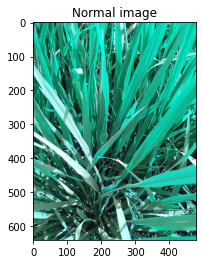

In [19]:
path = '../input/paddy-disease-classification/train_images/normal'

image = image_properties(path)
plt.imshow(image)
plt.title('Normal image')
print(f"The dimensions are {image.shape[0]} pixels height and {image.shape[1]} pixels width")
print(f"The maximum pixel value is {image.max():.2f}")
print(f"The minimum pixel value is {image.min():.2f}")
print(f"The mean value of the pixels is {image.mean():.2f}")
print(f"The standard deviation is {image.std():.2f}")

In [20]:
batch_size = 64
img_height = 256
img_width =  256

data_dir ='../input/paddy-disease-classification/train_images'

In [21]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                            rescale=1.0/255.0,
                            validation_split=0.3,
                            rotation_range=5,
                            shear_range=0.3,
                            zoom_range=0.3,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True
                )

In [22]:
train_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="training",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical",
                            color_mode='rgb'
            )

Found 7288 images belonging to 10 classes.


In [23]:
valid_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="validation",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical"
            )

Found 3119 images belonging to 10 classes.


In [24]:
print('Total No Of Classes in the datasetL:',len(train_gen.class_indices))
print('Class Names:',train_gen.class_indices)

Total No Of Classes in the datasetL: 10
Class Names: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


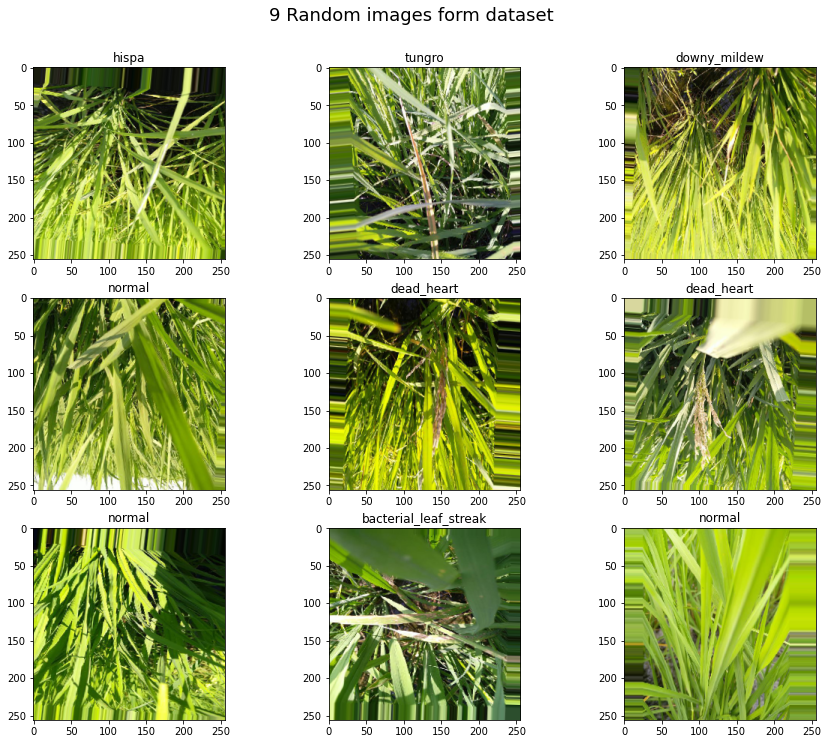

In [25]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)
fig.suptitle("9 Random images form dataset", fontsize=18, y=0.95)

for i in range(1,10):
    plt.subplot(3,3,i)
    img, label = train_gen.next()
    plt.title(list(train_gen.class_indices.keys())[np.argmax(label)])
    plt.imshow(img[0])

In [26]:
# terminate if loss was NaN
class TerminateNaN(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    loss = logs.get('loss')
    if loss is not None:
      if np.isnan(loss) or np.isinf(loss):
        print('Invalid loss and terminated at loss {}'.format(epoch))
        self.model.stop_training = True

terminate_nan = TerminateNaN()

In [27]:
# save model after every epoch if the validation accuracy improves from previous epoch
filepath = '/kaggle/working/every_epoch'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    monitor="val_categorical_accuracy",
    verbose=1,
    save_best_only=True,
    mode = 'auto'
)

In [28]:
# learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    factor=0.1,
    patience=1,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=3,
    min_lr=0
)

In [29]:
model_mobile_net = MobileNetV2(include_top = False, input_shape = (256,256,3), weights = '/kaggle/input/weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')

model_mobile_net.trainable = True

inputs = Input(shape=(256,256,3))
main = model_mobile_net(inputs, training = True)

x = layers.Flatten()(main)
x = layers.Dense(256, 'relu', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation='softmax', name= 'outputs')(x)

model_mobile_net = Model(inputs= [inputs], outputs= [outputs])


model_mobile_net.compile(optimizer=optimizers.Adam(3e-4), 
              metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)], 
              loss=losses.CategoricalCrossentropy(label_smoothing=0.1))

model_mobile_net.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_256 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               20971776  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
outputs (Dense)              (None, 10)                2570      
Total params: 23,233,354
Trainable params: 23,198,730
Non-trainable params: 34,624
__________________________________________

In [ ]:
history = model_mobile_net.fit(
    train_gen,
    batch_size = batch_size,
    validation_data = valid_gen,
    epochs=20,
    verbose=1,
    callbacks=[terminate_nan, checkpoint, reduce_lr]
)

Epoch 1/20
114/114 [==============================] - 743s 6s/step - loss: 1.6473 - categorical_accuracy: 0.5790 - val_loss: 1.3235 - val_categorical_accuracy: 0.7159

Epoch 00001: val_categorical_accuracy improved from -inf to 0.71593, saving model to /kaggle/working/every_epoch
Epoch 2/20
114/114 [==============================] - 721s 6s/step - loss: 1.0196 - categorical_accuracy: 0.7994 - val_loss: 1.0322 - val_categorical_accuracy: 0.8201

Epoch 00002: val_categorical_accuracy improved from 0.71593 to 0.82013, saving model to /kaggle/working/every_epoch
Epoch 3/20
114/114 [==============================] - ETA: 0s - loss: 0.8534 - categorical_accuracy: 0.8762

In [ ]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = model_mobile_net.history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model_mobile_net.evaluate(valid_gen)

In [ ]:
print('Validation Accuracy', accuracy)

In [ ]:
model_mobile_net.save('/kaggle/working/model.h5')

In [ ]:
# Load the model from the .h5 file
model_mobile_net = keras.models.load_model('/kaggle/working/model.h5')